# Assignment 3: Principal Components Analysis

**Diego Marcelo Gonzalez Lujan**

**Inteligencia artificial 2**

**Profesor: Dr Andrés Hernández Gutiérrez**

**IMT 588359**

**Febrero 16 del 2026**

**Doy mi palabra que realice esta actividad con integridad académica**

# Dataset Description 

Para este análisis de Componentes Principales (PCA), seleccioné el dataset llamado "Single Elder Home Monitoring: Gas and Position" [[2]](#ref2). Este conjunto de datos fue creado para desarrollar modelos de monitorieo de seguridad no invasivos para personas mayores que vivien solas.

El proposito del dataset es traducir la informacion recolectada por un arreglo de sensores de gas en un sistema de monitoreo de seguridad. La premisa es que los datos de los sensores de gas, combinados o contrastados con patrones de movimiento, puede servir como indicadores de "anomalias de actividad", un ejemplo de ello es que la persona de mayor edad deje la estufa encendida o que haya una fuga. 

* Variables del estudio: 

Variables Predictivas (Features): Cada instancia representa una medicon temporal de sensores de temperatura, humedad y concentraciones quimicas.

Integridad de los Datos: Segun la documentacion oficial, el dataset no contiene valores nulos ni requiere preprocesamiento de imputacion.


* Definicion de la Variable Objetivo

La documentacion explica que la unica division recomendada es la de los datos de referencia. Con esta informacion pude construir una variable de clasificacion para el PCA de la siguiente manera:

* Clase 1(Referencia) : Corresponde a los datos del archivo (data_ref), que representan el comportamiento base o de control.

* Clase 0 (Monitoreo): Corresponde al resto de los datos del sensor (database_gas), que representan el monitoreo continuo donde se busca desviaciones respecto a la referencia. 


# Data cleaning 

En esta parte de la tarea preparo los datos para asegurar que sean aptos para el calculo matematico del PCA. 

1. Carga y Sincronizacion: Se cargan los archivos y se normalizan los nombres de las columnas eliminando los espacios en blanco al inicio y al final (usando .strip()), para evitar errores de indexación.

2. Variable Objetivo: Construyo la variable llamada "target", para que todos los registros se marcan como 0 (Monitoreo), mediante un cruce de indices temporales, se actualizan a 1 (Referencia) aquellos registros que coninciden exactamente con el archivo  de control. 

3. Seleccionde Caracteristicas: Elimino la columna timestamp del dataset final, ya que el Analisis de Componentes Principales solamente necesita una matriz numerica y estatica. El resultado es un dataframe (df_final) listo para el analisis, conteniendo unicamente las lecturas de los sensores y la etiqueta de clase. 

¡Dataset listo!
Dimensiones finales: (416153, 10)


,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,target
0,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0,0
1,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0,0
2,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0,0
3,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0,0
4,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0,0


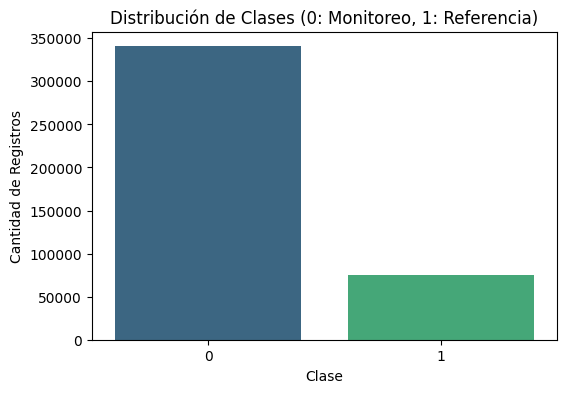

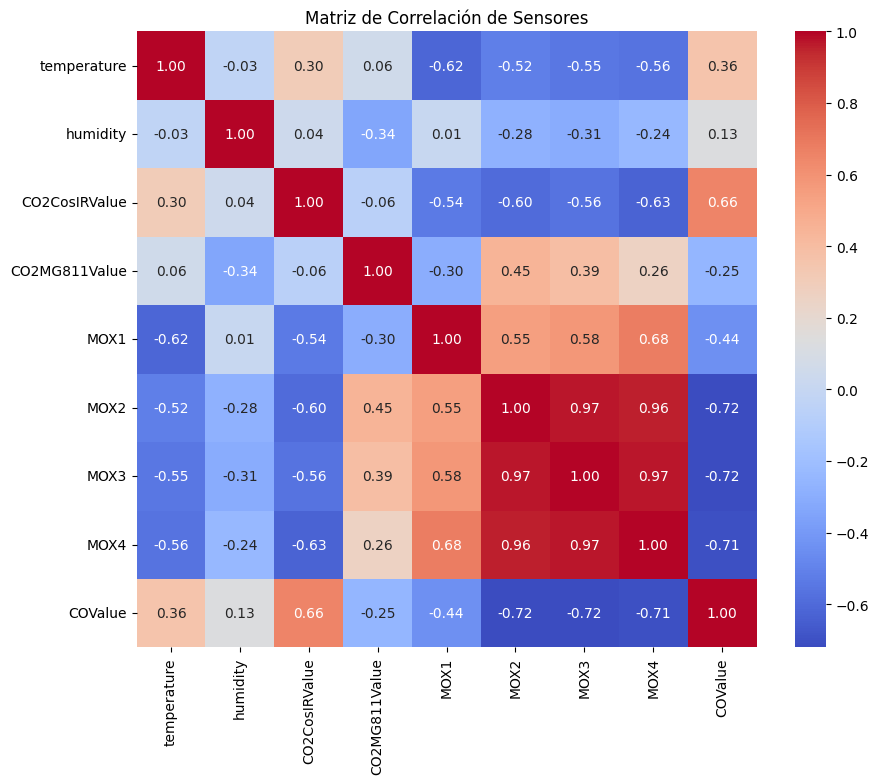

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_gas = pd.read_csv('database_gas.csv')
df_ref = pd.read_csv('data_ref_until_2020-02-13.csv')

#Quito espacios en los nombres de las columnas
df_gas.columns = df_gas.columns.str.strip()
df_ref.columns = df_ref.columns.str.strip()

#Convertir a formato de fecha para poder comparar
df_gas['timestamp'] = pd.to_datetime(df_gas['timestamp'])
df_ref['timestamp'] = pd.to_datetime(df_ref['timestamp'])

#Creo una columna llamada "target" lena de ceros para la Clase 0
df_gas['target'] = 0

#IDentificamos que filas pertenecen al archivo de referencia (Clase 1)
timestamps_referencia = set(df_ref['timestamp'])
df_gas.loc[df_gas['timestamp'].isin(timestamps_referencia), 'target'] = 1

#Creo el dataset final eliminando las fechas
df_final = df_gas.drop(columns=['timestamp'])

print("¡Dataset listo!")
print(f"Dimensiones finales: {df_final.shape}")
display(df_final.head())

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_final, palette='viridis', hue='target', legend=False)
plt.title('Distribución de Clases (0: Monitoreo, 1: Referencia)')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Registros')
plt.show()

plt.figure(figsize=(10, 8))

sns.heatmap(df_final.drop(columns=['target']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Sensores')
plt.show()

# Exploratory Data Analysis

Al revisar los graficos y estadisticas, identifique tres puntos clave para mi analisis:

1. Redundancia (Mapa de Calor): Observe que los sensores MOX1 al MOX4 tine una correlaciuon superior a 0.90. Esto justifica el uso de PCA, ya que podre comprimir estas 4 variables repetidas en un solo componente sin perder informacion. 

2. Clases (Grafico de Barras): Se confirma que la Clase 0 es mayoritaria frente a la Clase 1. Esto quiere decir que la referncia es solo un periodo base y el PCA aprendera la varianza principal de la operacion diaria. 

3. Escalas (Estadisticas): Note que el sensor C02 ronda los 500 mientras la temperatura esta en 20. 

# Principal Component Analysis Procedure


1. Data standardisation

El primer paso que necesitamos hacer para implementar PCA es la estandarizacion de los datos. Este proceso consiste en tranformar cada variable predictiva para que tenga una media de cero y una desviacion estandar de uno.

Al analizar los datos en la seccion pasada, note una disparidad en las magnitudes. Un ejemplo es el sensor de CO2 tiene un valor que ronda a los 500, mientras que la temperatura apenas llega a los 20 grados. Si aplico PCA directamente podria obtener un resultado engañoso en el algoritmo. 

Para evitar el resultado engañoso utilice la funcion 'StandardScaler'. Lo que hago es transformar cada una de las 9 variables para que todas tengan un promedio exacto de 0 y una desviacion estandar de 1. De esta forma, pongo a todos los en igualdad de condiciones, lo que ayuda al PCA a encontrar patrones basados en la correlacion real de los datos y no en las unidades de medida. 



In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Separación de Variables
# Separo las características (X) de la etiqueta (y).
# La etiqueta 'target' no se usa en el cálculo matemático, solo para validar después.
X = df_final.drop(columns=['target'])
y = df_final['target']

# Inicialización del Escalador
scaler = StandardScaler()

# Transformación 
# fit_transform calcula la media y desviación de cada columna y las transforma
X_std = scaler.fit_transform(X)

print("--- Proceso de Estandarización Completado ---")
print("Dimensiones de la matriz estandarizada:", X_std.shape)
print(f"Media global de los datos transformados: {np.mean(X_std):.2f} (Debe ser ~0)")
print(f"Desviación estándar global: {np.std(X_std):.2f} (Debe ser ~1)")

print("\nPrimeros 3 registros estandarizados:\n", X_std[:3])

--- Proceso de Estandarización Completado ---
Dimensiones de la matriz estandarizada: (416153, 9)
Media global de los datos transformados: 0.00 (Debe ser ~0)
Desviación estándar global: 1.00 (Debe ser ~1)

Primeros 3 registros estandarizados:
 [[-0.27691517  0.60405975  0.65443765  0.68452676 -0.48778848  0.39273063
  -0.65436208 -1.04081316  0.21881497]
 [-0.22900228  0.45900549  0.68006109  0.68452676 -0.46770613  0.39273063
  -0.65436208 -1.04081316  0.13546419]
 [-0.21157941  0.41756142  0.65443765  0.7704022  -0.44762378  0.42468271
  -0.65436208 -1.04081316  0.13546419]]


2. Covariance matrix

Una vez que los datos han sido estandarizados, el siguiente paso es calcular la Matriz de Coveraniza.

La Matriz de Coveranzia ayuda describir matematicamente como vairan las variables de entrada respecto a las otras.

* La Diagonal Principal. Representa la varianza de cada sensor individual. Dado que los datos estan estandarizados, todos estos valores deberian ser cercanos a 1.0.

* Los valores fuera de la diagonal: Representan la covarianza entre pares de sensores.

Un valor positivo alto (Deberia de ser cercano a 1) indica que ambos sensores aumentan su valor simultaneamente.

Un valor cercano a cero indica independenica lineal

La razon de porque tenemos que calcular esta matriz es para encontrar las relaciones fuertes entre variables de los sensores MOX para que el PCA pueda identificar los ejes principales. 



Matriz de Covarianza calculada exitosamente.
Dimensiones: (9, 9)


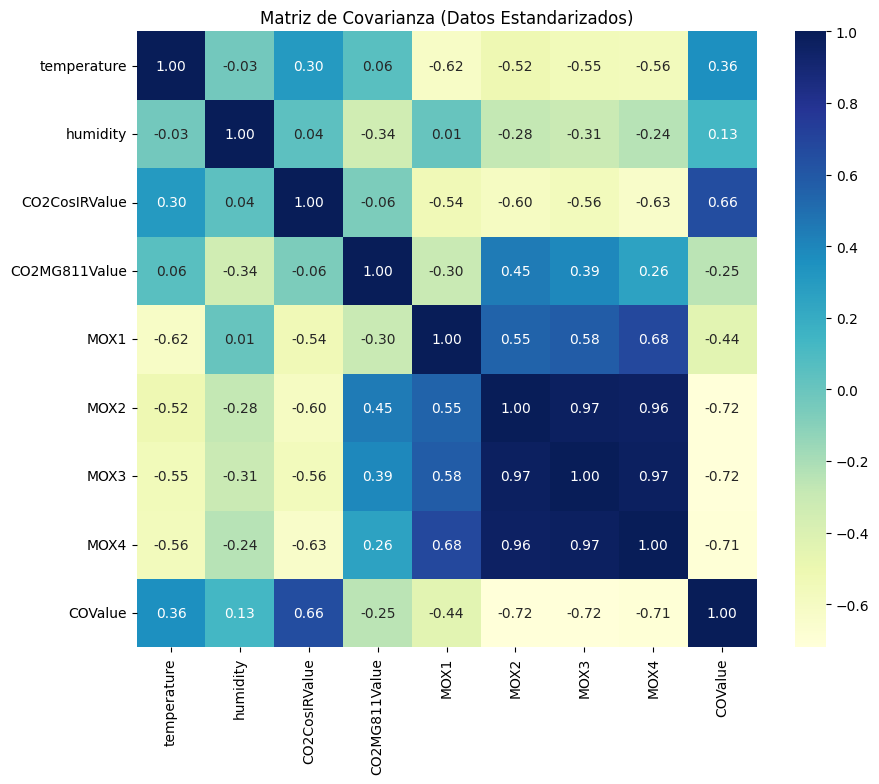

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Utilico álgebra lineal de numpy.
cov_matrix = np.cov(X_std.T)

print("Matriz de Covarianza calculada exitosamente.")
print("Dimensiones:", cov_matrix.shape)

# Visualización e Interpretación
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='YlGnBu', fmt='.2f', xticklabels=feature_names, yticklabels=feature_names)
plt.title("Matriz de Covarianza (Datos Estandarizados)")
plt.show()

3. Eigenvalues and eigenvectors

Una vez obtiendo la Matriz de Covarianza, el ultimo paso que tengo que realizar es una descomposicion espectral lo que ayuda en obtener dos elementos importaltes para el PCA:

1. Eigenvalues: Los valores propios representan la magnitud de la varianza capturada para cada componente. Un valor alto indica que ese componente contiene mucha informacion del dataset original. 

2. Eigenvectors: Los vectores propios indican la direccion de los nuevos ejes en el espacio multidimensional. Un eigenvectors alto indica que un componente retiene una gran parte de la informacion contenida en la dataset original. 

Este tipo de procedimiento consiste en calcular valores y odrenarlos de mayor a menor ya que los primeros componentes son los que guardan la mayor cantidad de informacion util. 


In [ ]:

# Descomposición matemática
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)

# Ordenamiento 
# Creo un índice que ordene de mayor a menor
idx_ordenados = np.argsort(eigen_vals)[::-1]

eigen_vals = eigen_vals[idx_ordenados]
eigen_vecs = eigen_vecs[:, idx_ordenados]

# Cálculo de la Varianza Explicada
# Calculo el porcentaje de información que aporta cada componente
total_var = sum(eigen_vals)
var_exp = [(i / total_var) for i in eigen_vals]
cum_var_exp = np.cumsum(var_exp) 

print("--- Resultados del Análisis de Componentes ---")
print("\nEigenvalues (Varianza capturada por componente):")
for i, val in enumerate(eigen_vals):
    print(f"Componente {i+1}: {val:.4f}  --> Explica el {var_exp[i]*100:.2f}% de la información")

print("\n--- Análisis de Varianza Acumulada ---")
print(f"Los primeros 2 componentes explican el: {cum_var_exp[1]*100:.2f}% del total.")
print(f"Los primeros 3 componentes explican el: {cum_var_exp[2]*100:.2f}% del total.")

--- Resultados del Análisis de Componentes ---

Eigenvalues (Varianza capturada por componente):
Componente 1: 4.9523  --> Explica el 55.03% de la información
Componente 2: 1.6567  --> Explica el 18.41% de la información
Componente 3: 0.8177  --> Explica el 9.09% de la información
Componente 4: 0.7097  --> Explica el 7.89% de la información
Componente 5: 0.3466  --> Explica el 3.85% de la información
Componente 6: 0.3121  --> Explica el 3.47% de la información
Componente 7: 0.1623  --> Explica el 1.80% de la información
Componente 8: 0.0281  --> Explica el 0.31% de la información
Componente 9: 0.0145  --> Explica el 0.16% de la información

--- Análisis de Varianza Acumulada ---
Los primeros 2 componentes explican el: 73.43% del total.
Los primeros 3 componentes explican el: 82.52% del total.


4. Transformation matrix

Una vez que tengo los eigenvectores ordenados por su importancia, procedo a construir la Matriz de Tranformacion.

Esta matriz la formo seleccionando los primeros K eigenvecotres de mi lista ordenada. En mi caso, decidi seleccionar los primeros dos para poder reducir el dataset de 9 dimensiones a un plano de 2 dimensiones. 

Para explicar mas a detalle, la Matris de Transformacion actua como un mapa de proyeccion. Matematicamente, realizo el producto punto entre mis datos originales estandarizados y esta matriz. El resultado se convertira en mi nuevo dataset transformado, donde las coordenadas ya no son sensores, sino Componentes Principales que resumen la mayor cantidad de informacion posible en un espacio reducido. 


In [7]:

# Definición de k 
# Elijo 2 para poder graficar en 2D
k = 2

# Creación de la Matriz 
# Tomo todas las primeras k (:)
matrix_w = eigen_vecs[:, :k]

print(f"Matriz de Transformación  construida para k={k}.")
print("Dimensiones de W:", matrix_w.shape)
print("\nValores de la Matriz de Transformación (Pesos de los sensores para PC1 y PC2):")
print(matrix_w)

Matriz de Transformación  construida para k=2.
Dimensiones de W: (9, 2)

Valores de la Matriz de Transformación (Pesos de los sensores para PC1 y PC2):
[[ 0.28174183  0.312242  ]
 [ 0.11341695 -0.47835903]
 [ 0.3228093   0.12952278]
 [-0.12939756  0.65087375]
 [-0.31548492 -0.4432633 ]
 [-0.4283684   0.1458338 ]
 [-0.43013247  0.11629139]
 [-0.43515197  0.0063672 ]
 [ 0.35973207 -0.04416673]]


Al analizar los pesos numericos de  la Matriz de Transformación, pude identificar que sensores gobiernan cada componentes:

1. En la primera columna en PC1, los valores negativos altos de **-0.43** en las filas correspondientes a los sensores **MOX2, MOX3 y MOX4**. Esto confirma que el Primer Componente Principal esta absorbiendo la redundancia de estos sensores de gas.

2. En la segunda columna en PC2, destaca un valor positivo de **0.65** en la cuarta fila, que corresponde al sensor **CO2MG811**. Esto indica que el segundo Componente Principal se especializa en capturar de este sensor CO2 especifico, Separandolo del ocmportamiento de los MOX.

5. Explained variance:

La Varianza Explicada es basicamente el porcentaje de informacion real que logro salvar en cada componente. Para calcularla, tomo el valor de cada componente y lo comparo contra el total.

Para visualizarlo y para tomar una decision, genere un Screen Plot. Esta grafica es importante para justificar cuantos componentes son necesarios: busco el punto donde la curva se aplana, lo que me indica que añadir mas componentes ya no aporta mucha informacion nueva y solo añadiria complejidad inecesaria.


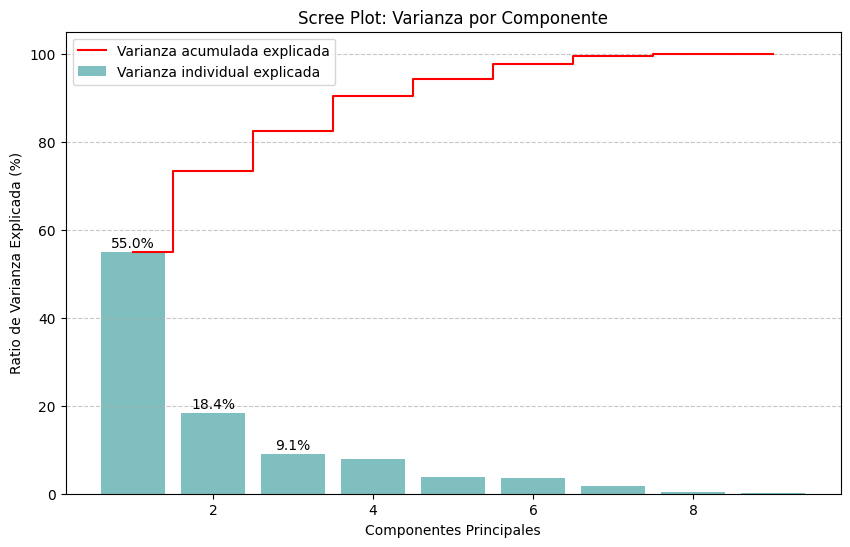

In [8]:
import matplotlib.pyplot as plt

# Preparación de datos para la gráfica
tot = sum(eigen_vals)
var_exp = [(i / tot) * 100 for i in eigen_vals]
cum_var_exp = np.cumsum(var_exp)

# Generación del Scree Plot
plt.figure(figsize=(10, 6))

# Gráfico de barras 
plt.bar(range(1, 10), var_exp, alpha=0.5, align='center',label='Varianza individual explicada', color='teal')

# Gráfico de línea 
plt.step(range(1, 10), cum_var_exp, where='mid',label='Varianza acumulada explicada', color='red')

plt.ylabel('Ratio de Varianza Explicada (%)')
plt.xlabel('Componentes Principales')
plt.title('Scree Plot: Varianza por Componente')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i, v in enumerate(var_exp[:3]): plt.text(i+1, v+1, f"{v:.1f}%", ha='center')

plt.show()

Al analizar el grafico de sendimentacion que obtuve, pude sacar estas conclusiones:

1. La primera barra es predominante. Por si sola explica el 55.03% de toda la varianza de los datos. Esto confirma visualmente lo que vi en la matriz de covarianza: la gran redundancia entre los sensores MOX represetnaba la mayor carga de informacion del sistema y ha sido capturada casi totalmente aqui. 

2. Al ver la varianza acumulada explicada, veo que la curva empieza a aplanarse despues del tercer componente. Esto sugiere que los primeros 2 o 3 componentes son los que realmente importan. Del componente 4 en adelante, las barras son muy pequeñas y aportan muy poco el valor individual.

3. Al sumar los dos primeros componentes, obtengo una varianza acumulada del **73.4%**. Esto significa que al reducir mi problema de 9 dimensiones a solamente 2, sigo conservando casi tres cuartas partes de la informacion original. Considero que este es un balance perfecto para poder visualizar los datos en un plano 2D sin perder la estructura del comportamiento del sistema.

5. First three principal components

Para derivar y visualizar los primeros tres componentes principales, el procedimiento consiste en construir una matriz de transformacion seleccionando las tres primeras columnas de los vectores propios ordenados. Esto proyecta nuestros datos origianles de 9 dimensiones a un subespacio de 3 dimensiones. 

Esta proyeccion retiene el 82.5% de la varianza total, lo cual permite observar la estructura espacial de los datos con alta fidelidad. Utilizo una grafica de dispersion 3D donde cada punto representa una medicion en el tiempo, para identificar si existe una separacion geometrica clara entre los estados del sistema. 

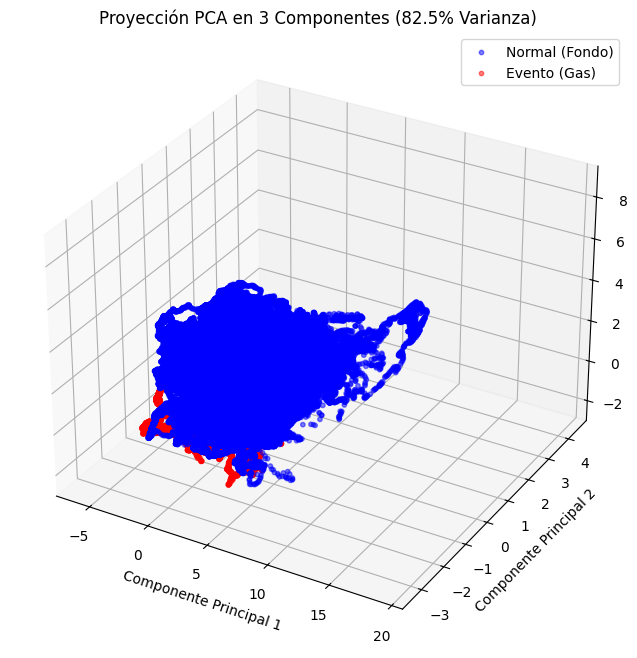

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Selecciono los primeros 3 vectores propios
W_3 = eigen_vecs[:, :3]

# Proyecto los datos originales (X_std) al nuevo espacio 3D
X_pca_3d = X_std.dot(W_3)

# Creación del DataFrame para graficar
df_pca_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['target'] = y.values  

# Visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


targets = [0, 1]
colors = ['b', 'r']
labels = ['Normal (Fondo)', 'Evento (Gas)']

for target, color, label in zip(targets, colors, labels):
    indicesToKeep = df_pca_3d['target'] == target
    ax.scatter(df_pca_3d.loc[indicesToKeep, 'PC1'], df_pca_3d.loc[indicesToKeep, 'PC2'],df_pca_3d.loc[indicesToKeep, 'PC3'], c=color, s=10, alpha=0.5, label=label)

ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Proyección PCA en 3 Componentes (82.5% Varianza)')
ax.legend()
plt.show()

Al observar la proyeccion 3D, podemos representar que los puntos azules es el estado normal, forman una nube densa y dispersa que ocupa la mayor parte del espacio central y superior. Por el otro lado, los puntos rojos, que correspnden al Gas, no estan mezclados aleatoriamente, sino que se agrupan en una region especifica, ubicada en la parte inferior de la estructura.

Este tipo de resultados es muy positivo. Muestra que, al utilizar tres dimensiones, exite una separabilidad clara entre cuando el sistema esta limpio y cuando hay presencia de gas. La direccion hacia donde se extiende los puntos rojos indica la correlacion de los sensores cuando reaccionan al estimulo quimico. 


6. First two principal components

Para derivar y visualizar los primeros dos componentes principales, repito el proceso de proyeccion pero limitando la matriz de transformacion a los dos primeros vectores propios. 

Aunque esta reducion implica una perdida de informacion que el modelo 3D, es la visualizacion mas util para analisis humano y para la toma de decisiones, ya que permite ver claramente las fronteras de decisiones lineales. El objetivo es evaluar si las clases son linealmente separables en este plano simplificado, lo que indicaria que un modelo de clasificacion simple funcionria eficientemente con estos datos reducidos. 

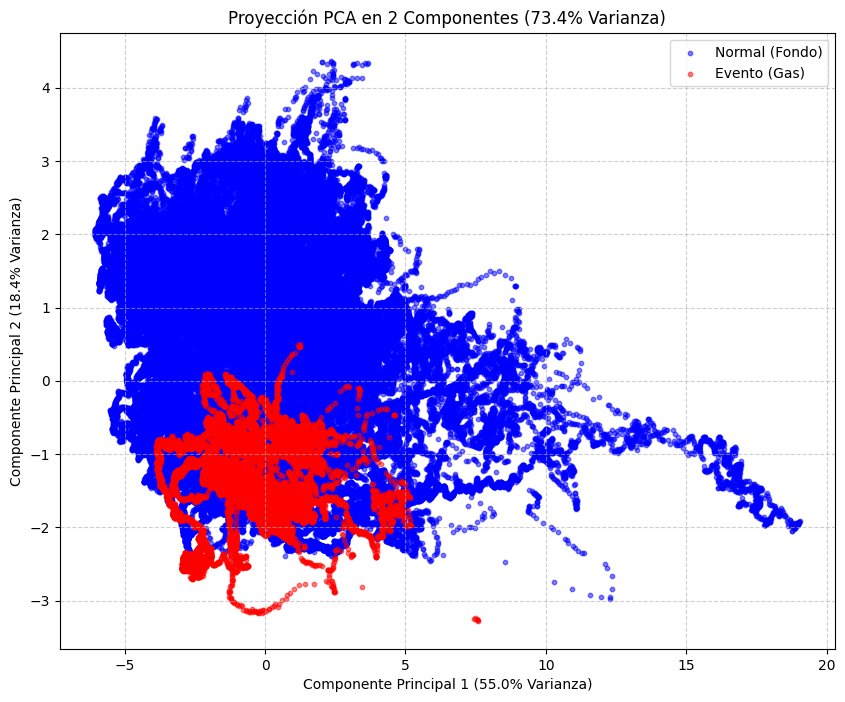

In [ ]:

# Selecciono los primeros 2 vectores propios
W_2 = eigen_vecs[:, :2]

# Proyecto los datos 
X_pca_2d = X_std.dot(W_2)

# Creación del DataFrame para graficar
df_pca_2d = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
df_pca_2d['target'] = y.values  

# Visualización 2D
plt.figure(figsize=(10, 8))
targets = [0, 1]
colors = ['b', 'r']
labels = ['Normal (Fondo)', 'Evento (Gas)']

for target, color, label in zip(targets, colors, labels):
    indicesToKeep = df_pca_2d['target'] == target
    plt.scatter(df_pca_2d.loc[indicesToKeep, 'PC1'],df_pca_2d.loc[indicesToKeep, 'PC2'],c=color, s=10, alpha=0.5, label=label)

plt.xlabel('Componente Principal 1 (55.0% Varianza)')
plt.ylabel('Componente Principal 2 (18.4% Varianza)')
plt.title('Proyección PCA en 2 Componentes (73.4% Varianza)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

En la proyeccion 2D, simplifique el sisteama a sus dos componentes mas importantes, reteniendo el 73.4% de la informacion. El eje x explica el 55.0% de la varianza y el eje y explica el 18.4%.

Aqui la distincion es facil de intepretar para la toma de decisiones:

1. Zona del Evento: Vemos que los puntos rojos que corresponden al gas se concentran fuertemente en una zona especifica, principalmente con valores bajos o negativos en el componente 2. Esto sugiere que el segundo componente principal es muy sensible a la presencia del gas. 

2. Separabilidad: Aunque los puntos rojos estan dentro del rango horizontal de los azules, se distinguen claramente por su posicion vertical y densidad. No estan dispersos por todo el grafico, sino formando un nucleo compacto. 

# Conclusion

1. Effectiveness of PCA for the selected dataset

La aplicacion del Analisis de Componentes Principales en este conjunto de datos de sensores de gas resulto ser altamente efectiva. Lorgre reducir la dimensionalidad de 9 variables originales a solo 2 Componentes Principales, reeteniendo el 73.4% de la informacion original (varianza). Esta reduccion significativa, eliminando 7 variable sde entrada, se logro sin perder la señal necesaria para distinguir entre el estadode fondo y los eventos de gas, como lo demuestra la agrupacion de la proyeccion 2D.

2. Insights gained from dimensionality reduction

El analisis revelo dos hallazgos principales sobre la fisica del sistema. Primero, detectamos una redundancia masiva entre los sensores MOX (oxido de  metal); el primer componente (PC1) capturo el 55.03% de la varianza y estuvo dominando por estos sensores, lo que indica que miden variaciones muy similares y no necesitamos lo cuatro para detectar el gas. Segundo, descubirmos independencia quimica; el segundo componete (PC2) estuvo dominando por el sensor de C02, demostrando que el dioxido de carbono se comporta de manera independiente a los otros gases. Esto confirma que el sisteam esta detectando al menos dos fenomenos quimicos distintos.

3. Suitability of the reduced feature space for neuron model architectures

El espacio de caracrerisitcas reducido a 2D es altamente adecuado para entrenar arquitecturas de modelos neuronales enfocados en clasificacion. El analisis de la grafica 2D muestra que la clase Evento de gas forma un grupo distinto de la clase Normal. Aunque no son perfectamente separable slinealmente en los bordes, la densidad de los grupos es lo suficientemente clara para que una red neuronal parenda una frontera de decisiones con alta precision. 

**Los datasets que uso en esta tarea estan pesadas, aqui voy a poner un link de los datasets que use para esta tarea**

https://drive.google.com/drive/folders/1a3oUw-efwsgODZvkb4vYfoi1C-edt296?usp=sharing

**Link del Github:** https://github.com/DiegoLujan198/02-Principal-Component-Analysis

# Referencias

<a id="ref1"></a>
[1] Kumar, A. (2023, noviembre 24). PCA explained variance concepts with Python example. Analytics Yogi. https://vitalflux.com/pca-explained-variance-concept-python-example/


<a id="ref2"></a>
[2] UCI machine learning repository. (s/f). Uci.edu. Recuperado el 17 de febrero de 2026, de https://archive.ics.uci.edu/dataset/799/single+elder+home+monitoring+gas+and+position


<a id="ref3"></a>
[3] What is the difference between eigenvalues and eigenvectors? (2024, junio 28). GeeksforGeeks. https://www.geeksforgeeks.org/artificial-intelligence/what-is-the-difference-between-eigenvalues-and-eigenvectors/

